# ESAME DI TECNICHE DI RAPPRESENTAZIONE E MODELLIZZAZIONE DEI DATI

## Studio del profilo di densità NFW e stima della massa e della concentrazione di aloni di materia oscura

Il progetto ha lo scopo di stimare i parametri fisici degli aloni di materia oscura (massa e concentrazione) a partire da simulazioni cosmologiche. Il metodo si basa sulla modellizzazione analitica del profilo di densità proiettato (NFW), l'analisi statistica dei dati simulati, e l'uso di tecniche di inferenza bayesiana tramite MCMC (`emcee`).

Il codice è strutturato in **quattro parti**:
1. **Modello analitico del profilo NFW (2D)**
2. **Analisi dei dati simulati con binning per ricchezza**
3. **Stima dei parametri con campionamento MCMC**
4. **Valutazione dei risultati: fit, intervalli di confidenza, $\chi^2$**


## PARTE A: Modello Analitico 2D del Profilo NFW

In questa sezione si definisce un modello teorico del profilo di densità proiettato degli aloni secondo la formulazione NFW.  
Viene costruita una classe `Density` che calcola i parametri caratteristici (raggio di scala $r_s$, densità caratteristica $\rho_s$) e la funzione $\Sigma(R,M,c,z)$.

Si producono dei grafici che mostrano il comportamento del profilo $\Sigma$ al variare della massa totale dell'alone e della concentrazione.


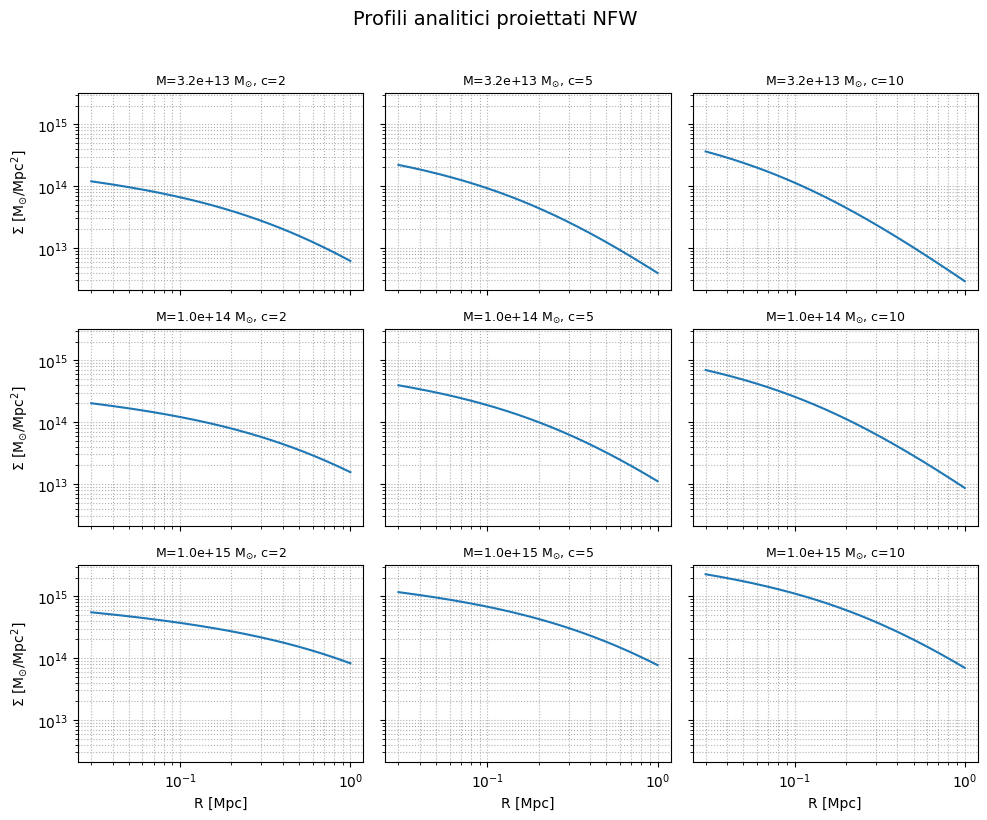

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import pandas as pd
import emcee
import corner

class Density:
    def __init__(self, M, c, z=0.0):
        self.M, self.c, self.z = M, c, z
        self.rhoun = 0.286 * 0.7**2 * 2.7751428946e11  # M☉/Mpc³
        self.rs   = self.compute_rs()
        self.rhos = self.compute_rhos()

    def compute_rs(self):
        rhom = self.rhoun * (1 + self.z)**3
        return (3*self.M / (4*np.pi*200*rhom))**(1/3) / self.c

    def compute_rhos(self):
        fc = np.log(1 + self.c) - self.c/(1 + self.c)
        delta_char = 200 * self.c**3 / (3 * fc)
        rhom = self.rhoun * (1 + self.z)**3
        return rhom * delta_char

    def f(self, x):
        x = np.asarray(x)
        y = np.zeros_like(x)
        m1, m2, m3 = x<1, x==1, x>1
        y[m1] = (1/(x[m1]**2 - 1) * (1 - 2/np.sqrt(1 - x[m1]**2) * np.arctanh(np.sqrt((1 - x[m1])/(1 + x[m1])))))
        y[m2] = 1/3
        y[m3] = (1/(x[m3]**2 - 1) * (1 - 2/np.sqrt(x[m3]**2 - 1) * np.arctan(np.sqrt((x[m3] - 1)/(x[m3] + 1)))))
        return y

    def density_profile(self, R):
        x = R / self.rs
        return 2 * self.rs * self.rhos * self.f(x)

# Profili analitici
M_vals = [10**13.5, 10**14, 10**15]
c_vals = [2, 5, 10]
R_ana  = np.linspace(0.03, 1.0, 300)

fig1, axs1 = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
for i, M in enumerate(M_vals):
    for j, c in enumerate(c_vals):
        σ = Density(M, c).density_profile(R_ana)
        ax = axs1[i, j]
        ax.plot(R_ana, σ, lw=1.5)
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.set_title(f"M={M:.1e} M$_⊙$, c={c}", fontsize=9)
        ax.grid(True, which='both', ls=':')
        if i == 2: ax.set_xlabel("R [Mpc]")
        if j == 0: ax.set_ylabel("Σ [M$_⊙$/Mpc$^2$]")
fig1.suptitle("Profili analitici proiettati NFW", y=1.02, fontsize=14)
fig1.tight_layout()
plt.show()


## PARTE B: Dati Simulati, Binning e Analisi Statistica

In questa parte si caricano i dati provenienti da simulazioni cosmologiche (`halo_catalog.fit`) e si suddividono gli aloni in 5 gruppi (bin) in base alla loro ricchezza (`λ`, direttamente correlata alla massa totale dell'alone).  
Per ciascun gruppo si calcola il profilo medio di densità proiettata `Σ(R)` e la sua deviazione standard.  
I risultati vengono rappresentati con barre di errore e confrontati con un modello NFW tratteggiato.


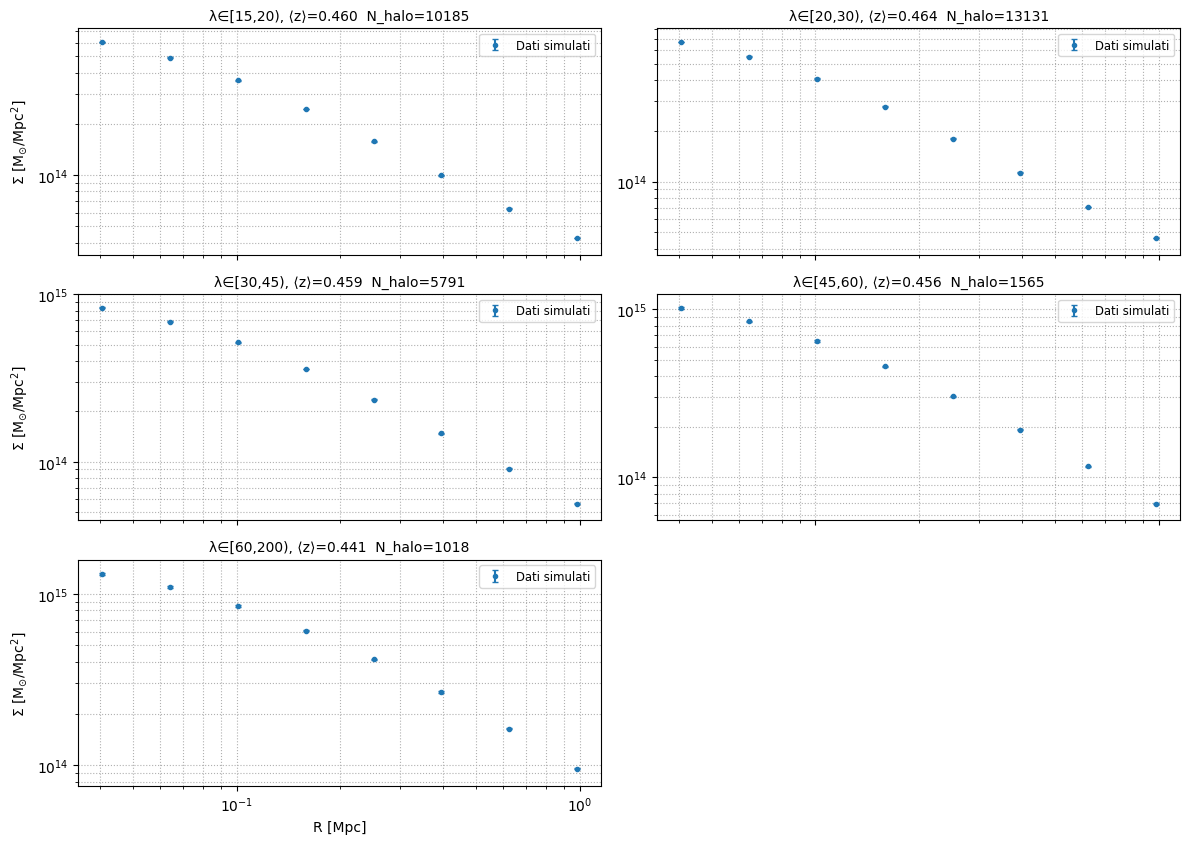

In [88]:
# 1) Carico dati
hdul = fits.open('halo_catalog.fit')
data = hdul[1].data
hdul.close()
z_arr      = data['Z']
lambda_arr = data['LAMBDA_TR']
sigmaR_arr = data['SIGMA_of_R']
R = np.load('R_values.npy')

# 2) Binning in λ e calcolo media ± errore della media
bins = [15, 20, 30, 45, 60, 200]
results = []
for lo, hi in zip(bins[:-1], bins[1:]):
    sel     = (lambda_arr >= lo) & (lambda_arr < hi)
    N_halo  = sel.sum()
    zmean   = z_arr[sel].mean() if N_halo>0 else np.nan

    if N_halo>0:
        mat        = np.vstack(sigmaR_arr[sel])
        mean_prof  = mat.mean(axis=0)
        std_prof   = mat.std(axis=0)
        stderr_prof= std_prof / np.sqrt(N_halo)
    else:
        mean_prof   = np.full_like(R, np.nan)
        stderr_prof = np.full_like(R, np.nan)

    results.append({
        'range':  (lo, hi),
        'zmean':  zmean,
        'mean':   mean_prof,
        'std':    std_prof,
        'stderr': stderr_prof,
        'N_halo': int(N_halo)
    })

# 3) Parametri per la curva teorica (esempio fisso o proveniente da stima successiva)
M_theo = 1e14   # massa di riferimento
c_theo = 5      # concentrazione di riferimento

# 4) Plot: punti dati ± stderr e curva teorica NFW
fig2, axs2 = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=False)
axs_flat = axs2.flatten()
for idx, res in enumerate(results):
    ax = axs_flat[idx]
    lo, hi = res['range']

    # Punti dati con barre di errore (errore sulla media)
    ax.errorbar(R, res['mean'], yerr=res['stderr'],
                fmt='o', ms=3, capsize=2, label="Dati simulati")

   

    # Impostazioni grafiche
    ax.set_xscale('log'); ax.set_yscale('log')
    valid = res['mean'] > 0
    y_lo = np.min(res['mean'][valid] - res['stderr'][valid])
    y_hi = np.max(res['mean'][valid] + res['stderr'][valid])
    ax.set_ylim(y_lo*0.8, y_hi*1.2)

    ax.grid(True, which='both', ls=':')
    ax.set_title(f"λ∈[{lo},{hi}), ⟨z⟩={res['zmean']:.3f}  N_halo={res['N_halo']}",
                 fontsize=10)
    if idx in (0,2,4): ax.set_ylabel("Σ [M$_⊙$/Mpc$^2$]")
    if idx >= 4:     ax.set_xlabel("R [Mpc]")
    ax.legend(fontsize='small')

# Rimuovo l'ultimo subplot vuoto
axs_flat[5].axis('off')
fig2.tight_layout(rect=[0,0,1,0.95])
plt.show()

# 5) Salvataggio dei CSV
pd.DataFrame([{
    'lambda_min': lo,
    'lambda_max': hi,
    'N_halo':     res['N_halo'],
    'z_mean':     res['zmean']
} for res in results for lo,hi in [res['range']]]).to_csv('bin_summary.csv', index=False)

profile_dict = {'R [Mpc]': R}
for res in results:
    lo, hi = res['range']
    profile_dict[f'mean_{lo}_{hi}']  = res['mean']
    profile_dict[f'sterr_{lo}_{hi}'] = res['stderr']
pd.DataFrame(profile_dict).to_csv('profiles_by_bin.csv', index=False)

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Z</th>
      <th>LAMBDA_TR</th>
      <th>SIGMA_of_R</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.502494</td>
      <td>290.692261</td>
      <td>[2351102000000000.0, 1992653000000000.0, 14960...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.601302</td>
      <td>119.245781</td>
      <td>[2107659200000000.0, 1980063800000000.0, 16522...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>0.208961</td>
      <td>126.373863</td>
      <td>[1814137000000000.0, 1739587000000000.0, 13446...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.212769</td>
      <td>188.812729</td>
      <td>[2349731000000000.0, 1945844900000000.0, 15394...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.458008</td>
      <td>147.349625</td>
      <td>[2240655000000000.0, 1679704500000000.0, 13142...</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>lambda_min</th>
      <th>lambda_max</th>
      <th>n_halos</th>
      <th>z_mean</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>15</td>
      <td>20</td>
      <td>10185</td>
      <td>0.460090</td>
    </tr>
    <tr>
      <th>1</th>
      <td>20</td>
      <td>30</td>
      <td>13131</td>
      <td>0.463887</td>
    </tr>
    <tr>
      <th>2</th>
      <td>30</td>
      <td>45</td>
      <td>5791</td>
      <td>0.459208</td>
    </tr>
    <tr>
      <th>3</th>
      <td>45</td>
      <td>60</td>
      <td>1565</td>
      <td>0.456439</td>
    </tr>
    <tr>
      <th>4</th>
      <td>60</td>
      <td>200</td>
      <td>1018</td>
      <td>0.441161</td>
    </tr>
  </tbody>
</table>
</div>


## Implementazione dell’algoritmo *emcee* per la stima di log$_{10}M$ e $c$

Utilizziamo il campionatore MCMC **emcee** per inferire la massa log$_{10}M$ (in $M_\odot$) e la concentrazione $c$ di ciascun bin di ricchezza.

---

### 1&nbsp;&nbsp;Funzioni di probabilità

1. **Prior (uniforme con tagli fisici)**  

   $$
     p(\log_{10}M,\,c)=
     \begin{cases}
       \dfrac{1}{(16-13)\,(20-0.2)} &
       13<\log_{10}M<16,\; 0.2<c<20,\\[6pt]
       0 & \text{altrimenti.}
     \end{cases}
   $$

2. **Likelihood (errori indipendenti)**  

   $$
     \ln\mathcal{L} \;=\;
     -\tfrac12\sum_i
       \frac{\bigl[\Sigma_{\text{data}}(R_i)
                  -\Sigma_{\text{mod}}(R_i;\log_{10}M,c)\bigr]^2}
            {\sigma_i^2},
   $$
   dove $\sigma_i$ è l’errore **sulla media** del profilo
   $ \sigma_i = \mathrm{std}(R_i)/\sqrt{N_{\text{halo}}} $.

3. **Posterior**  

   $$
     \ln p(\log_{10}M,c \mid \text{dati}) =
     \ln p_{\text{prior}} + \ln\mathcal{L}.
   $$

---

### 2&nbsp;&nbsp;Set-up di *emcee*

| Parametro   | Valore | Note |
|-------------|--------|------|
| Walker      | 32     | ≈ 10 × n-param. |
| Passi totali| 2000   | ≫ tempo di autocorrelazione |
| Burn-in     | 500    | prime iterazioni scartate |
| Thinning    | 10     | 1 campione ogni 10 |

Inizializzazione dei walker  
$$
  \log_{10}M \sim \mathcal{U}(13,16), \quad
  c \sim \mathcal{U}(0.2,20).
$$

---

### 3&nbsp;&nbsp;Procedura per ciascun bin

1. **Selezione** del profilo medio Σ(R) e degli errori $\sigma_i$.  
2. **Esecuzione**  

   ```python
   sampler = emcee.EnsembleSampler(
       32, 2, log_posterior,
       args=(data_i, 1/σ_i**2, R, z_mean)
   )
   sampler.run_mcmc(p0, 2000, progress=True)
   chain  = sampler.get_chain(discard=500, thin=10, flat=True)
   logpdf = sampler.get_log_prob(discard=500, thin=10, flat=True)
Salvataggio: samples e logprob vengono inseriti in results
(e, se necessario, salvati su disco).

---
### 4&nbsp;&nbsp;Output
Per ogni intervallo di ricchezza memorizziamo soltanto:

la catena piatta samples (≈ 1500 – 2000 campioni) di
$(\log_{10}M,,c)$;
il log-posterior logprob per ciascun campione.
Questi dati saranno impiegati nella Parte D per:

estrarre il best-fit (massimo log-posterior);
calcolare media ± σ dei parametri;
generare il triangle plot dei posteriori;
valutare il $\chi^{2}$ del best-fit e la distribuzione
$\chi^{2}_{\text{pp}}$ (posterior predictive);
salvare i risultati finali in file CSV e PNG.

In [89]:
cov_matrices = np.load('Sigma-cov.npy')

def log_prior(theta):
    logM10, c = theta
    return 0.0 if (13.0 < logM10 < 16.0 and 0.2 < c < 20.0) else -np.inf

def log_likelihood(theta, data, cov_inv, R, z):
    logM10, c = theta
    model = Density(10**logM10, c, z).density_profile(R)
    delta = data - model
    return -0.5 * delta @ (cov_inv @ delta)

def log_posterior(theta, data, cov_inv, R, z):
    lp = log_prior(theta)
    return lp + log_likelihood(theta, data, cov_inv, R, z) if np.isfinite(lp) else -np.inf

n_dim, n_walkers = 2, 32
n_steps, burn_in, thin = 2000, 500, 10
for i, res in enumerate(results):
    lo, hi  = res['range']
    data_i  = res['mean']
    cov     = cov_matrices[i]
    cov_inv = np.linalg.inv(cov)
    zmean   = res['zmean']

    p0 = np.zeros((n_walkers, n_dim))
    p0[:,0] = np.random.uniform(13.0, 16.0, n_walkers)
    p0[:,1] = np.random.uniform(0.2, 20.0, n_walkers)

    sampler = emcee.EnsembleSampler(
        n_walkers, n_dim, log_posterior,
        args=(data_i, cov_inv, R, zmean)
    )
    sampler.run_mcmc(p0, n_steps, progress=True)

    flat_samps = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
    flat_logp  = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)

    # salviamo le catene dentro results
    res['samples'] = flat_samps
    res['logprob'] = flat_logp

    # --- qui aggiungiamo le stampe ---
    # mediana ± σ
    med, err = np.median(flat_samps, axis=0), np.std(flat_samps, axis=0)
    print(f"Bin λ∈[{lo},{hi}): median log₁₀M = {med[0]:.3f} ± {err[0]:.3f}, "
          f"c = {med[1]:.3f} ± {err[1]:.3f}")

    # best‐fit (massimo log‐posterior)
    idx_best = np.argmax(flat_logp)
    best_M10, best_c = flat_samps[idx_best]
    print(f"               best-fit log₁₀M = {best_M10:.3f}, c = {best_c:.3f}\n")


100%|██████████| 2000/2000 [00:13<00:00, 149.21it/s]


Bin λ∈[15,20): median log₁₀M = 14.301 ± 0.101, c = 2.969 ± 1.356
               best-fit log₁₀M = 14.331, c = 2.694



100%|██████████| 2000/2000 [00:11<00:00, 171.00it/s]


Bin λ∈[20,30): median log₁₀M = 14.381 ± 0.097, c = 3.064 ± 1.315
               best-fit log₁₀M = 14.407, c = 2.814



100%|██████████| 2000/2000 [00:11<00:00, 170.46it/s]


Bin λ∈[30,45): median log₁₀M = 14.540 ± 0.093, c = 3.347 ± 1.324
               best-fit log₁₀M = 14.570, c = 3.021



100%|██████████| 2000/2000 [00:11<00:00, 170.43it/s]


Bin λ∈[45,60): median log₁₀M = 14.701 ± 0.088, c = 3.493 ± 1.229
               best-fit log₁₀M = 14.721, c = 3.320



100%|██████████| 2000/2000 [00:11<00:00, 171.24it/s]


Bin λ∈[60,200): median log₁₀M = 14.887 ± 0.113, c = 3.859 ± 1.440
               best-fit log₁₀M = 14.925, c = 3.558



## Parte D – Analisi finale delle catene MCMC

In questa fase partiamo dalle catene campionate in **Parte C** e,
per ogni bin di ricchezza λ, ricaviamo i parametri best-fit, le incertezze
e alcune diagnostiche di bontà del fit.

---

### 1&nbsp;&nbsp;Estrazione delle statistiche principali

* **Best-fit** – il campione con log-posterior massimo.  
* **Mediana** e **σ** – momenti della distribuzione campionata  
  (deviazione standard come stima dell’errore a 1σ).

---

### 2&nbsp;&nbsp;Corner plot dei posteriori

Per visualizzare la distribuzione congiunta di $(\log_{10}M,\;c)$
utilizziamo un diagramma a triangolo che mostra:

* le proiezioni 1-D (istogrammi) di ciascun parametro;
* le contour 2-D al 68 % e 95 %.

---

### 3&nbsp;&nbsp;Calcolo di χ² e χ² ridotto

Per il profilo teorico NFW ai parametri best-fit
si definiscono i residui

$$
\Delta_i = \Sigma_{\text{mod}}(R_i) \;-\;
           \Sigma_{\text{data}}(R_i)
$$

e si valuta il test chi-quadrato

$$
\chi^{2} \;=\;
\sum_{i}\frac{\Delta_i^{2}}{\sigma_i^{2}},\qquad

$$

---

### 4&nbsp;&nbsp;Posterior-predictive χ²

Estraiamo 100 campioni casuali dalla catena e,
per ciascuno, calcoliamo lo stesso $\chi^{2}$.
Dai 100 valori otteniamo i percentili 16 / 50 / 84 %,
fornendo un intervallo atteso sotto il modello.

---

### 5&nbsp;&nbsp;Output

Per ogni bin salviamo:

| Quantità | Descrizione |
|----------|-------------|
| `best_logM10`, `best_c` | parametri best-fit |
| `err_logM10`, `err_c`   | errore 1 σ (dev. std. della catena) |
| `chi2`, `chi2_red`      | chi-quadrato e chi-quadrato ridotto |
| `pp16`, `pp50`, `pp84`  | percentili 16/50/84 della distrib. χ²<sub>pp</sub> |

Tutti i risultati sono raccolti nel file **`fits_emcee_full.csv`**
e i corner-plot in PNG, da cui si ricavano le figure riepilogative
per il report finale.


In [90]:


fits_full = []
for i, res in enumerate(results):
    lo, hi    = res['range']
    samples   = res['samples']
    logp      = res['logprob']
    data_i    = res['mean']
    zmean     = res['zmean']
    
    # Uso la diagonale della matrice di covarianza per σ_i
    sigma_i = np.sqrt( np.diagonal(cov_matrices[i]) ) 
    cov_inv_vec = 1.0 / (sigma_i**2)

    # best-fit (massima posterior)
    idx_best    = np.argmax(logp)
    best_logM10, best_c = samples[idx_best]

    # mediana e incertezza (σ) della catena
    med_logM10, med_c = np.median(samples, axis=0)
    err_logM10, err_c = np.std   (samples, axis=0)

    # corner plot
    fig = corner.corner(
        samples,
        labels=["log₁₀M₁₀", "c"],
        truths=[best_logM10, best_c],
        show_titles=True,
        title_fmt=".3f",
        title_kwargs={"fontsize":8}
    )
    fig.savefig(f"triangle_bin_{int(lo)}_{int(hi)}.png", dpi=150)
    plt.close(fig)

    # modello best-fit e residui
    model_best = Density(10**best_logM10, best_c, zmean).density_profile(R)
    delta_best = model_best - data_i

    # χ² classico con σ_i dalla covarianza
    chi2     = np.sum(delta_best**2 / (sigma_i**2))

    # gradi di libertà e χ² ridotto
    N_data, N_param = len(data_i), 2
    nu = N_data - N_param
    chi2_red = chi2 / nu

    # posterior predictive χ²
    idxs     = np.random.choice(len(samples), 100, replace=False)
    chi2_pp  = []
    for s in samples[idxs]:
        m = Density(10**s[0], s[1], zmean).density_profile(R)
        chi2_pp.append(np.sum((m - data_i)**2 / (sigma_i**2)))
    chi2_pp = np.array(chi2_pp)
    p16, p50, p84 = np.percentile(chi2_pp, [16, 50, 84])

    # raccolta risultati
    fits_full.append({
        'lambda_min':  lo,
        'lambda_max':  hi,
        'best_logM10': best_logM10,
        'err_logM10':  err_logM10,
        'best_c':      best_c,
        'err_c':       err_c,
        'chi2':        chi2,
        'chi2_red':    chi2_red,
        'pp16':        p16,
        'pp50':        p50,
        'pp84':        p84
    })

# salvo csv con tutte le quantità
pd.DataFrame(fits_full).to_csv('fits_emcee_full.csv', index=False)
dfs = pd.read_csv('fits_emcee_full.csv')
dfs


,lambda_min,lambda_max,best_logM10,err_logM10,best_c,err_c,chi2,chi2_red,pp16,pp50,pp84
0,15,20,14.330697,0.101206,2.694322,1.356000,0.571228,0.095205,1.047764,2.413889,5.700246
1,20,30,14.407450,0.097450,2.814272,1.314905,0.457724,0.076287,1.046648,2.212675,3.804842
2,30,45,14.569655,0.092842,3.021342,1.324371,0.273686,0.045614,0.569475,1.494948,4.528198
3,45,60,14.721074,0.087951,3.320024,1.228938,0.182112,0.030352,0.611213,1.641208,4.123564
4,60,200,14.924723,0.113170,3.558412,1.439571,0.068205,0.011368,0.626935,1.672214,3.952818


**Discussione sul valore di χ²**

Il test chi-quadrato utilizza
$$
\chi^{2} = \sum_i \frac{\bigl[\Sigma_{\text{mod}}(R_i)-\Sigma_{\text{data}}(R_i)\bigr]^2}{\sigma_i^{2}},
\qquad
\sigma_i^{2} = C_{ii}.
$$

Poiché $C_{ii}$ riflette la **dispersione complessiva fra aloni**
(non il solo errore statistico della media)
le $\sigma_i$ sono sovrastimate rispetto all’incertezza sul profilo medio.
I residui $\Delta_i$ risultano quindi molto piccoli in unità di
$\sigma_i$, producendo un χ² “troppo buono” (≪ i gradi di libertà)
anche quando il modello si limita a descrivere la media dei dati.


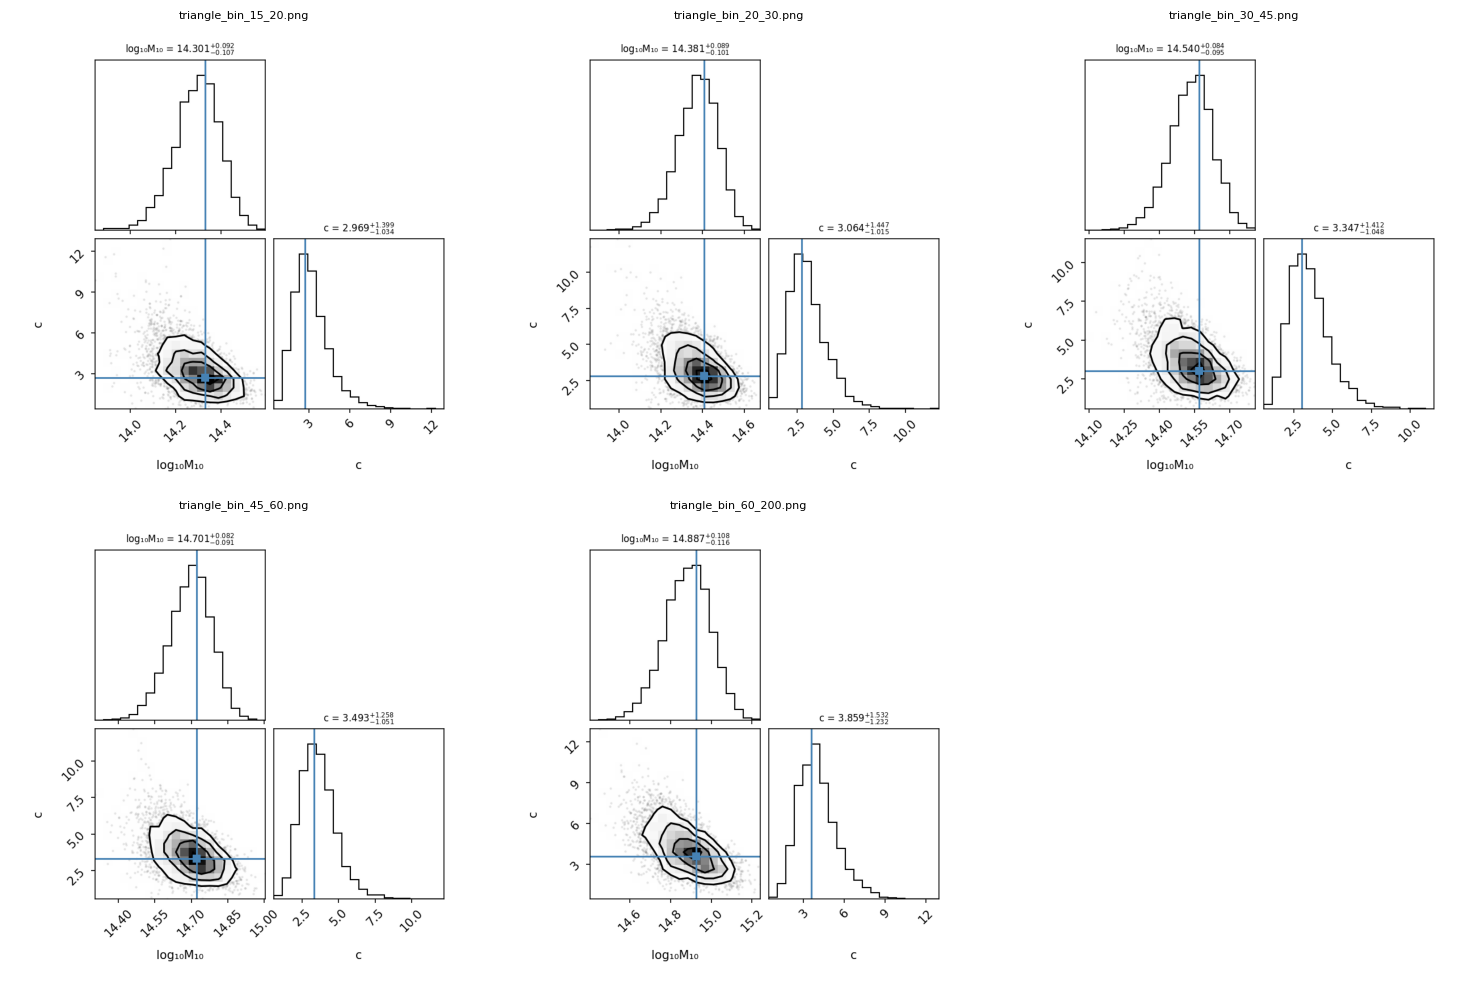

In [91]:
import matplotlib.image as mpimg

# List your five filenames
files = ["triangle_bin_15_20.png", "triangle_bin_20_30.png", "triangle_bin_30_45.png", "triangle_bin_45_60.png", "triangle_bin_60_200.png"]

# Create a grid: e.g. 2 rows × 3 columns (one slot will remain empty)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, fn in zip(axes, files):
    img = mpimg.imread(fn)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(fn, fontsize=8)

# Hide the last empty subplot if any
for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Confronto finale: profili simulati vs. modello NFW best-fit

Nell’ultimo grafico tracciamo, per ciascun bin di ricchezza λ:

1. **Punti con barre d’errore**  
   *Coordinate* → raggio $R_i$ (ascissa) e profilo medio  
   $\langle\Sigma_{\text{sim}}(R_i)\rangle$ (ordinata).  
   *Errore verticale* = $\sigma_i / \sqrt{N_{\text{halo}}}$  
   (errore sulla media del profilo).

2. **Linea tratteggiata**: profilo NFW calcolato ai **parametri best-fit**  
   estratti dalla catena MCMC (massimo log-posterior):
   $$
     \bigl(\log_{10}M_{\star},\,c_{\star}\bigr)
     = \arg\max\!\bigl[\ln p(\log_{10}M, c \mid \text{dati})\bigr].
   $$

L’intero layout è un grigliato 3 × 2:
* ogni riquadro mostra un intervallo di λ, indicato nel titolo;  
* assi log-log $(R,\Sigma)$ condivisi;  
* la leggenda riporta i parametri best-fit di quel bin.

Il risultato visivo consente di verificare
quanto il profilo teorico (linea arancione) descriva
i dati medi (punti blu) lungo tutti gli ordini di grandezza
in raggio e superficie di massa.


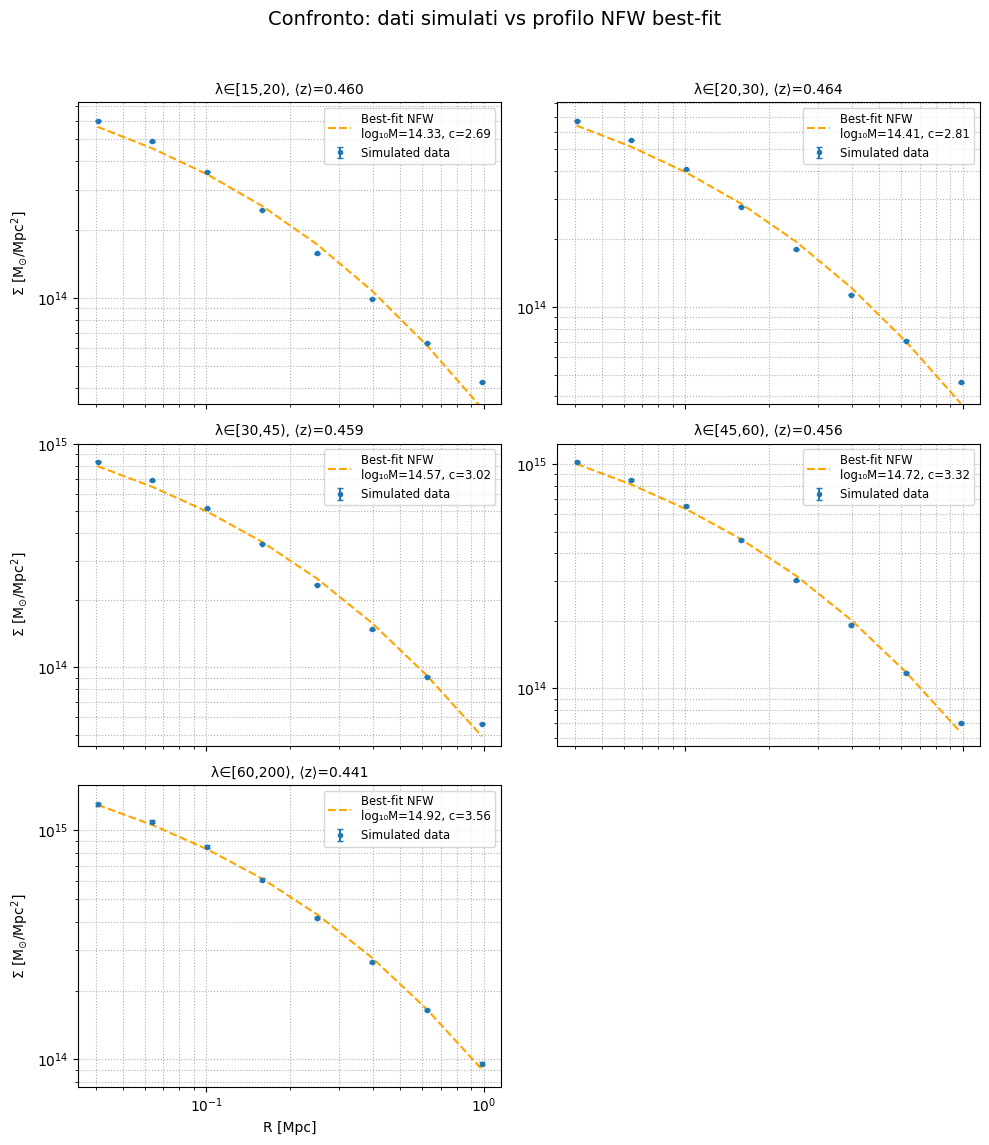

In [92]:

fig3, axs3 = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=False)
axs3_flat = axs3.flatten()
for idx, res in enumerate(results):
    lo, hi   = res['range']
    mean_prof= res['mean']
    std_prof = res['stderr']
    zmean    = res['zmean']
    R_vals   = R

    # prendi il best‐fit dal logprob salvato
    idx_best = np.argmax(res['logprob'])
    best_logM10, best_c = res['samples'][idx_best]
    # calcola il profilo NFW con i parametri stimati
    nfw_model = Density(10**best_logM10, best_c, zmean).density_profile(R_vals)

    ax = axs3_flat[idx]
    # scatter con barre di errore verticali
    ax.errorbar(
        R_vals,
        mean_prof,
        yerr=std_prof,
        fmt='o',
        ms=3,
        capsize=2,
        label='Simulated data'
    )
    # linea del modello NFW best-fit
    ax.plot(
        R_vals,
        nfw_model,
        '--',
        color='orange',
        lw=1.5,
        label=f'Best‐fit NFW\nlog₁₀M={best_logM10:.2f}, c={best_c:.2f}'
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    # regola y‐limits attorno ai dati
    valid = mean_prof > 0
    y_min = np.min(mean_prof[valid] - std_prof[valid])
    y_max = np.max(mean_prof + std_prof)
    ax.set_ylim(y_min*0.8, y_max*1.2)

    ax.grid(True, which='both', ls=':')
    ax.set_title(f"λ∈[{lo},{hi}), ⟨z⟩={zmean:.3f}", fontsize=10)
    if idx in (0,2,4):
        ax.set_ylabel("Σ [M$_⊙$/Mpc$^2$]")
    if idx >= 4:
        ax.set_xlabel("R [Mpc]")
    ax.legend(fontsize='small', loc='upper right')

# nascondi eventuale subplot vuoto
if len(results) < len(axs3_flat):
    axs3_flat[len(results)].axis('off')

fig3.suptitle(
    "Confronto: dati simulati vs profilo NFW best‐fit",
    y=0.95,
    fontsize=14
)
fig3.tight_layout(rect=[0,0,1,0.93])
plt.show()
